# Turing Target Practice

## Model

In [1]:
#] activate "."

In [16]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot

using Revise
using MicroCanonicalHMC

In [17]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [18]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [19]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.3)
    σ8 ~ Uniform(0.5, 1.1)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [20]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [21]:
target = TuringTarget(stat_model);

In [22]:
spl = MCHMC(0.0, 0.0, varE_wanted=0.01) #sqrt(target.d)*0.01

MicroCanonicalHMC.Sampler(Settings(Random.MersenneTwister(0), 1.0, 0.01, 0, 1000, 100, "LF", nothing, nothing, nothing), Hyperparameters(0.0, 0.0, 0.0, 0.1931833275037836, [0.0]), MicroCanonicalHMC.Leapfrog)

In [23]:
samples_mchmc = Sample(spl, target, 20000;
                       monitor_energy=true, 
                       dialog=true, initial_x = [0.2360, 0.8684])

Using eps tuning method AdaptiveStep
eps: 0.5 --> VarE/d: 7.2581312413012755
eps: 0.19650059357113955 --> VarE/d: 6.150593837444331
eps: 0.11792732675769502 --> VarE/d: 1.2011816680010405
eps: 0.08636058114367087 --> VarE/d: 0.35512262124910465
eps: 0.07143888817789688 --> VarE/d: 0.07179853459383598
eps: 0.0653130408844243 --> VarE/d: 0.0161966302853628
eps: 0.06411654350637343 --> VarE/d: 0.0158235546510394
eps: 0.06317589412023886 --> VarE/d: 0.005159250928489753
eps: 0.06435040406926021 --> VarE/d: 0.0037308851875538923
eps: 0.06592534948190518 --> VarE/d: 0.030753403246652506
eps: 0.06431175170425137 --> VarE/d: 0.001278986369317986
eps: 0.06693760698707384 --> VarE/d: 0.018793857964935032
eps: 0.06614271037461619 --> VarE/d: 0.0045457425326541415
eps: 0.06706551798262085 --> VarE/d: 0.0072350230263090514
eps: 0.0674265740824056 --> VarE/d: 0.0015441207917693542
eps: 0.06934164842488437 --> VarE/d: 0.03183701286116856
eps: 0.06817421304904354 --> VarE/d: 0.0826976432997253
eps: 0.

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Initial nu 0.7169780267370375
[ Info: Found eps: 0.07090639816604798 ✅
[ Info: Found L: 0.8728901146314171 ✅
[ Info: Final nu 0.29698939093005206


20001-element Vector{Any}:
 [0.236, 0.8684000000000001, 0.0, 14.523716244287751]
 [0.23601553911987078, 0.8783976056342637, -0.38229107239247284, 14.39583948929696]
 [0.23657484705518783, 0.8876289085547504, -0.5628950314679599, 14.207008200726678]
 [0.23723516628647665, 0.8964585551240056, -0.7355396286289189, 13.959699054109713]
 [0.23829963001842977, 0.9037304051770496, -0.7691499362184331, 13.696195780784475]
 [0.2398735804558188, 0.9070994377093667, -0.46083699246237764, 13.530334028543189]
 [0.24143904159935078, 0.9033396294008016, 0.2935089999741489, 13.636645390376081]
 [0.24220272284162842, 0.8948439757343909, 0.813905064120247, 13.91607839154494]
 [0.24265655470308833, 0.8855081954019995, 0.7666869250631212, 14.175137836146007]
 [0.24304774600781906, 0.875896709449641, 0.6064507222075388, 14.379408509184337]
 [0.24344071100523604, 0.8661170423206543, 0.41917675723673575, 14.520541334390016]
 [0.2440666911622432, 0.8566053349450615, 0.2113212987820301, 14.592174389343628]
 [0.

In [24]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

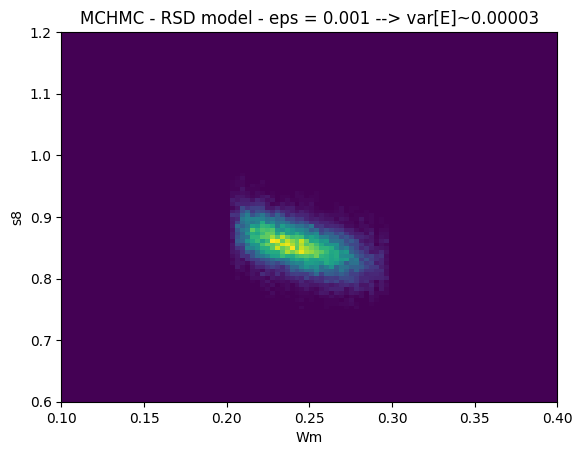

In [25]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [12]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 20000;
    monitor_energy=true, 
    dialog=true, initial_x = [0.2360, 0.8684])

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 4.3716141539854005
eps: 0.25 --> VarE: 1.9719460685294679


[ Info: Found eps: 0.25 ✅
[ Info: Tuning L ⏳


samples: 100--> ESS: 0.30121331176103416


[ Info: Found L: 1.4142135623730951 ✅
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (20000×4×1 Array{Float64, 3}):

Iterations        = 1:1:20000
Number of chains  = 1
Samples per chain = 20000
Wall duration     = 3.47 seconds
Compute duration  = 3.47 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2340    0.0659     0.0005    0.0030   284.5467    1.0025     ⋯
          σ8    0.8697    0.0631     0.0004    0.0026   374.8223    1.0063     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1309    0.1863    0.2263    0.2717    0.3828
          σ8    0.7550    0.8261    0.8669    0.9101    1.0029


In [13]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 20000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (20000×4×1 Array{Float64, 3}):

Iterations        = 1:1:20000
Number of chains  = 1
Samples per chain = 20000
Wall duration     = 2.06 seconds
Compute duration  = 2.06 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2331    0.0650     0.0005    0.0030   387.8946    1.0014     ⋯
          σ8    0.8711    0.0639     0.0005    0.0027   500.4907    1.0005     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1278    0.1871    0.2252    0.2705    0.3799
          σ8    0.7567    0.8275    0.8677    0.9102    1.0108


In [14]:
#StatsPlots.plot(new_samples)

## NUTS

In [15]:
samples_hmc = sample(stat_model, NUTS(1000, 0.65), MCMCThreads(),
                     20000, 4, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.8
┌ Info: Found initial step size
└   ϵ = 0.8
┌ Info: Found initial step size
└   ϵ = 0.8
┌ Info: Found initial step size
└   ϵ = 0.8
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/ha

Chains MCMC chain (20000×14×4 Array{Float64, 3}):

Iterations        = 1001:1:21000
Number of chains  = 4
Samples per chain = 20000
Wall duration     = 11.98 seconds
Compute duration  = 47.59 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

          Ωm    0.2357    0.0674     0.0002    0.0004   23257.1571    1.0001   ⋯
          σ8    0.8687    0.0636     0.0002    0.0004   22796.3593    1.0000   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

   

In [16]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 1001:1:21000
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:4
And data, a 20000×14×4 Array{Float64, 3}:
[:, :, 1] =
 0.277984  0.858993  13.9801  5.0  1.0  …  2.0  0.0  0.671676  0.671676
 0.277984  0.858993  13.9801  1.0  1.0     1.0  0.0  0.671676  0.671676
 0.186067  0.873481  13.9541  7.0  1.0     3.0  0.0  0.671676  0.671676
 0.196717  0.897298  14.2924  3.0  1.0     2.0  0.0  0.671676  0.671676
 0.280811  0.829563  14.2816  7.0  1.0     2.0  0.0  0.671676  0.671676
 0.280811  0.829563  14.2816  1.0  1.0  …  1.0  0.0  0.671676  0.671676
 0.286226  0.829277  14.2163  3.0  1.0     2.0  0.0  0.671676  0.671676
 0.31221   0.836839  13.6289  1.0  1.0     1.0  0.0  0.671676  0.671676
 0.314187  0.871138  12.3939  3.0  1.0     1.0  0.0  0.671676 

In [17]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

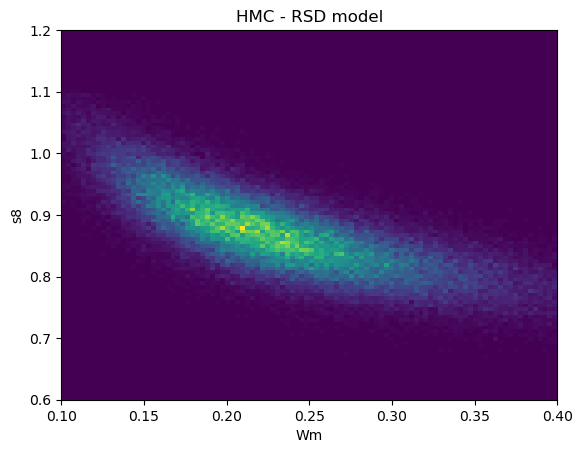

In [18]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");